# Individual Assignment: Advanced Clustering & Density Methods

**Name:** `Shajeel_Rehman`  

This notebook follows the exact requirements provided:
- Loads four real-world datasets from `scikit-learn`: **Iris**, **Wine**, **Breast Cancer**, **Digits**.
- Implements **K-Means variants** (Classic random init, **K-Means++**, **Bisecting K-Means**).
- Uses scikit-learn for **DBSCAN** and **AgglomerativeClustering** (Ward & Complete).
- Computes **Inertia** (where defined), **Silhouette**, and **Adjusted Rand Index (ARI)**.
- Produces **PCA 2D scatterplots** for exploration and for each algorithm (representative *k* per dataset).
- Performs **hyperparameter sensitivity** (K-Means `k` sweep and DBSCAN `eps`×`min_samples` heatmap) on a challenging dataset.
- Includes short **reflections** after each major section and a final **3-takeaways** summary.


In [13]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.utils import check_random_state

RNG = np.random.default_rng(42)


# Important Note: 

I've implemented everything in step 2 (aloghrithm implementation and baseline) before step 1 (lodading the dataset) so that I visiualize the datasets easily.

In [14]:
def pca_2d(X, n_components=2, random_state=42):
    p = PCA(n_components=n_components, random_state=random_state)
    return p.fit_transform(X), p

def plot_scatter_2d(X2d, labels=None, title='', alpha=0.85):
    plt.figure(figsize=(6,5))
    if labels is None:
        plt.scatter(X2d[:,0], X2d[:,1], alpha=alpha)
    else:
        plt.scatter(X2d[:,0], X2d[:,1], c=labels, alpha=alpha)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()

def inertia_score(X, labels, centroids):
    sse = 0.0
    for k in range(len(centroids)):
        cluster_points = X[labels == k]
        if len(cluster_points) == 0:
            continue
        diffs = cluster_points - centroids[k]
        sse += np.sum(diffs * diffs)
    return sse


In [15]:
def kmeans_random_init(X, k, random_state=42):
    rng = check_random_state(random_state)
    idx = rng.choice(X.shape[0], size=k, replace=False)
    return X[idx].copy()

def kmeans_plus_plus_init(X, k, random_state=42):
    rng = check_random_state(random_state)
    n_samples, _ = X.shape
    centers = []
    first = rng.randint(n_samples)
    centers.append(X[first])
    for _ in range(1, k):
        _, d2 = pairwise_distances_argmin_min(X, np.array(centers))
        total = d2.sum()
        if total <= 0:
            probs = np.full_like(d2, 1.0/len(d2))
        else:
            probs = d2 / total
        next_idx = rng.choice(n_samples, p=probs)
        centers.append(X[next_idx])
    return np.array(centers)

def _assign_labels(X, centers):
    labels, d2 = pairwise_distances_argmin_min(X, centers)
    return labels, d2

def _recompute_centers(X, labels, k):
    centers = np.zeros((k, X.shape[1]))
    for i in range(k):
        pts = X[labels == i]
        if len(pts) == 0:
            centers[i] = X[np.random.randint(0, X.shape[0])]
        else:
            centers[i] = pts.mean(axis=0)
    return centers


In [16]:
def kmeans_fit(X, k, init='random', max_iter=300, tol=1e-4, random_state=42):
    start = time.time()
    if init == 'random':
        centers = kmeans_random_init(X, k, random_state=random_state)
    elif init == 'kmeans++':
        centers = kmeans_plus_plus_init(X, k, random_state=random_state)
    else:
        raise ValueError("init must be 'random' or 'kmeans++'")
    prev_inertia = None
    it = 0
    for it in range(1, max_iter+1):
        labels, d2 = _assign_labels(X, centers)
        inertia = d2.sum()
        centers = _recompute_centers(X, labels, k)
        if prev_inertia is not None and abs(prev_inertia - inertia) <= tol * (prev_inertia + 1e-9):
            break
        prev_inertia = inertia
    runtime = time.time() - start
    labels, d2 = _assign_labels(X, centers)
    inertia = d2.sum()
    return {
        'centroids': centers,
        'labels': labels,
        'inertia': float(inertia),
        'iterations': it,
        'runtime_sec': runtime
    }


In [17]:
def bisecting_kmeans(X, k, base_init='kmeans++', max_iter=100, random_state=42):
    all_idx = np.arange(X.shape[0])
    init_res = kmeans_fit(X, 1, init='kmeans++', max_iter=max_iter, random_state=random_state)
    clusters = [{
        'indices': all_idx,
        'centroid': init_res['centroids'][0],
        'inertia': init_res['inertia']
    }]
    while len(clusters) < k:
        split_idx = int(np.argmax([c['inertia'] for c in clusters]))
        to_split = clusters.pop(split_idx)
        Xsub = X[to_split['indices']]
        res2 = kmeans_fit(Xsub, 2, init=base_init, max_iter=max_iter, random_state=random_state)
        labels2 = res2['labels']
        for sub_k in [0,1]:
            sub_indices = to_split['indices'][labels2 == sub_k]
            sub_centroid = res2['centroids'][sub_k]
            diffs = X[sub_indices] - sub_centroid
            sub_inertia = float(np.sum(diffs * diffs))
            clusters.append({'indices': sub_indices, 'centroid': sub_centroid, 'inertia': sub_inertia})
    labels = np.full(X.shape[0], -1, dtype=int)
    centroids = []
    for new_label, c in enumerate(clusters):
        labels[c['indices']] = new_label
        centroids.append(c['centroid'])
    centroids = np.array(centroids)
    total_inertia = inertia_score(X, labels, centroids)
    return {'centroids': centroids, 'labels': labels, 'inertia': float(total_inertia), 'iterations': None, 'runtime_sec': None}


In [18]:
def evaluate_clustering(X, labels, true_labels=None, centroids=None):
    metrics = {}
    if centroids is not None and np.min(labels) >= 0:
        metrics['inertia'] = inertia_score(X, labels, centroids)
    else:
        metrics['inertia'] = np.nan
    if labels is not None and len(np.unique(labels)) > 1 and (np.unique(labels) != [-1]).any():
        try:
            metrics['silhouette'] = silhouette_score(X, labels)
        except Exception:
            metrics['silhouette'] = np.nan
    else:
        metrics['silhouette'] = np.nan
    if true_labels is not None:
        try:
            metrics['ARI'] = adjusted_rand_score(true_labels, labels)
        except Exception:
            metrics['ARI'] = np.nan
    else:
        metrics['ARI'] = np.nan
    return metrics

def timed(func, *args, **kwargs):
    t0 = time.time()
    res = func(*args, **kwargs)
    t1 = time.time()
    return res, t1 - t0


## 1. Dataset Selection & Exploration

We load four real-world datasets from scikit-learn:
1. **Iris** – compact, roughly Gaussian clusters.
2. **Wine** – skewed feature scales and higher dimensionality (13 features).
3. **Breast Cancer** – non-spherical, varying density (30 features).
4. **Digits** – high-dimensional (64 features), non-convex clusters.

For each, we scale with `StandardScaler` and visualize via **PCA (2D)**.

In [19]:
from collections import OrderedDict


datasets_info = OrderedDict()

# Iris
iris = datasets.load_iris()
X_iris, y_iris = iris.data, iris.target
Xs_iris = StandardScaler().fit_transform(X_iris)
X2d_iris, _ = pca_2d(Xs_iris)
datasets_info['Iris'] = {'source':'scikit-learn load_iris()', 'n_samples': X_iris.shape[0], 'n_features': X_iris.shape[1],
                         'n_classes': len(np.unique(y_iris)), 'scaled': True, 'X': Xs_iris, 'y': y_iris, 'X2d': X2d_iris}

# Wine
wine = datasets.load_wine()
X_wine, y_wine = wine.data, wine.target
Xs_wine = StandardScaler().fit_transform(X_wine)
X2d_wine, _ = pca_2d(Xs_wine)
datasets_info['Wine'] = {'source':'scikit-learn load_wine()', 'n_samples': X_wine.shape[0], 'n_features': X_wine.shape[1],
                         'n_classes': len(np.unique(y_wine)), 'scaled': True, 'X': Xs_wine, 'y': y_wine, 'X2d': X2d_wine}

# Breast Cancer
bc = datasets.load_breast_cancer()
X_bc, y_bc = bc.data, bc.target
Xs_bc = StandardScaler().fit_transform(X_bc)
X2d_bc, _ = pca_2d(Xs_bc)
datasets_info['Breast Cancer'] = {'source':'scikit-learn load_breast_cancer()', 'n_samples': X_bc.shape[0], 'n_features': X_bc.shape[1],
                                  'n_classes': len(np.unique(y_bc)), 'scaled': True, 'X': Xs_bc, 'y': y_bc, 'X2d': X2d_bc}

# Digits
digits = datasets.load_digits()
X_digits, y_digits = digits.data, digits.target
Xs_digits = StandardScaler().fit_transform(X_digits)
X2d_digits, _ = pca_2d(Xs_digits)
datasets_info['Digits'] = {'source':'scikit-learn load_digits()', 'n_samples': X_digits.shape[0], 'n_features': X_digits.shape[1],
                           'n_classes': len(np.unique(y_digits)), 'scaled': True, 'X': Xs_digits, 'y': y_digits, 'X2d': X2d_digits}

summary_rows = []
for name, d in datasets_info.items():
    summary_rows.append({'Dataset': name, 'Source': d['source'], 'Samples': d['n_samples'], 'Features': d['n_features'],
                         'Classes (for eval)': d['n_classes'], 'Scaled': d['scaled']})
summary_df = pd.DataFrame(summary_rows)
display('Dataset Summary', summary_df)
summary_df


'Dataset Summary'

,Dataset,Source,Samples,Features,Classes (for eval),Scaled
0,Iris,scikit-learn load_iris(),150,4,3,True
1,Wine,scikit-learn load_wine(),178,13,3,True
2,Breast Cancer,scikit-learn load_breast_cancer(),569,30,2,True
3,Digits,scikit-learn load_digits(),1797,64,10,True


,Dataset,Source,Samples,Features,Classes (for eval),Scaled
0,Iris,scikit-learn load_iris(),150,4,3,True
1,Wine,scikit-learn load_wine(),178,13,3,True
2,Breast Cancer,scikit-learn load_breast_cancer(),569,30,2,True
3,Digits,scikit-learn load_digits(),1797,64,10,True


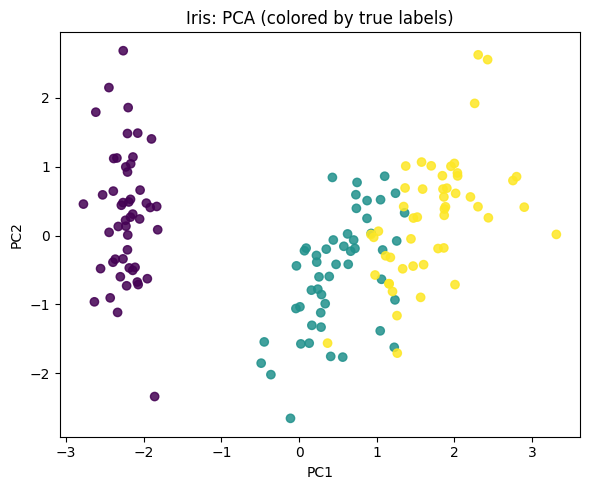

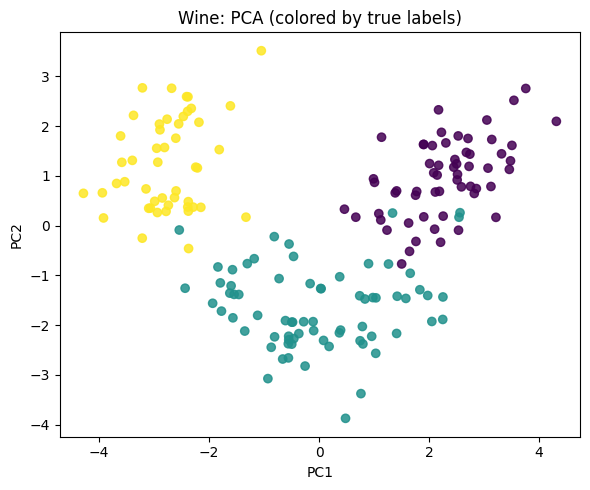

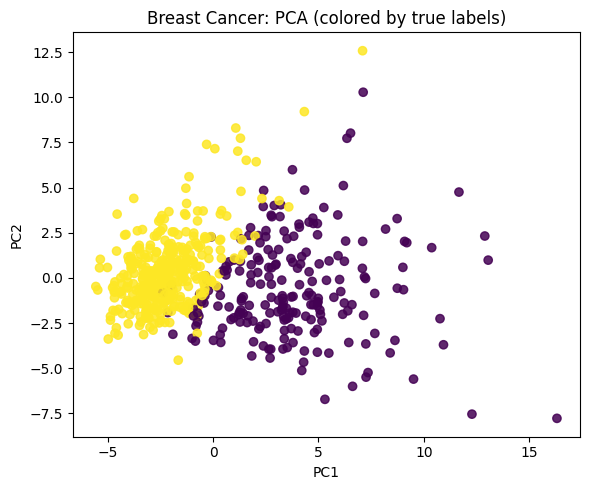

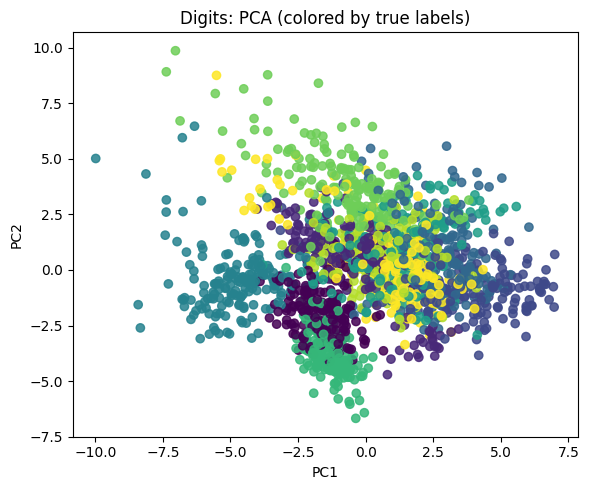

In [20]:
for name, d in datasets_info.items():
    plot_scatter_2d(d['X2d'], d['y'], title=f"{name}: PCA (colored by true labels)")


**Reflection:**  
Choosing a projection that is both fast and revealing was key; **PCA** is quick and stable, but it can miss non-linear separations that **t-SNE/UMAP** might capture. I also verified that **scaling** is essential (especially for Wine & Breast Cancer) to keep distances meaningful across features.

## 2. Algorithm Implementations & Baselines

### 2.1 K-Means Variants
- **Classic (random init)**
- **K-Means++**
- **Bisecting K-Means**

### 2.2 Density & Hierarchical
- **DBSCAN** (grid for `eps`, `min_samples`, choose best silhouette)
- **Agglomerative** (Ward & Complete)


In [21]:
def run_all_algorithms(X, y, k_rep, dataset_name, random_state=42):
    records = []
    (res_rnd, rt_rnd) = timed(kmeans_fit, X, k_rep, init='random', random_state=random_state)
    rec = {'Dataset': dataset_name, 'Algo': 'KMeans-Random', 'k': k_rep, 'runtime_sec': rt_rnd, 'iterations': res_rnd['iterations']}
    rec.update(evaluate_clustering(X, res_rnd['labels'], y, res_rnd['centroids']))
    records.append(rec)

    (res_pp, rt_pp) = timed(kmeans_fit, X, k_rep, init='kmeans++', random_state=random_state)
    rec = {'Dataset': dataset_name, 'Algo': 'KMeans++', 'k': k_rep, 'runtime_sec': rt_pp, 'iterations': res_pp['iterations']}
    rec.update(evaluate_clustering(X, res_pp['labels'], y, res_pp['centroids']))
    records.append(rec)

    (res_bis, rt_bis) = timed(bisecting_kmeans, X, k_rep, random_state=random_state)
    rec = {'Dataset': dataset_name, 'Algo': 'Bisecting KMeans', 'k': k_rep, 'runtime_sec': rt_bis, 'iterations': np.nan}
    rec.update(evaluate_clustering(X, res_bis['labels'], y, res_bis['centroids']))
    records.append(rec)

    eps_grid = np.linspace(0.5, 3.0, 6) if X.shape[1] < 20 else np.linspace(1.5, 6.0, 6)
    min_samples_grid = [3,5,10]
    best_db = None
    best_score = -np.inf
    best_tuple = None
    for eps in eps_grid:
        for ms in min_samples_grid:
            start = time.time()
            db = DBSCAN(eps=eps, min_samples=ms).fit(X)
            rt = time.time() - start
            labels = db.labels_
            if len(np.unique(labels[labels!=-1])) > 1:
                try:
                    sil = silhouette_score(X, labels)
                except Exception:
                    sil = np.nan
            else:
                sil = np.nan
            if np.nan_to_num(sil, nan=-9999) > best_score:
                best_score = np.nan_to_num(sil, nan=-9999)
                best_db = (db, rt)
                best_tuple = (eps, ms)
    if best_db is not None:
        db, rt_db = best_db
        labels = db.labels_
        core_count = db.core_sample_indices_.shape[0] if hasattr(db, 'core_sample_indices_') else np.nan
        rec = {'Dataset': dataset_name, 'Algo': f'DBSCAN(best eps={best_tuple[0]:.2f}, ms={best_tuple[1]})', 'k': np.nan,
               'runtime_sec': rt_db, 'iterations': np.nan}
        rec.update(evaluate_clustering(X, labels, y, centroids=None))
        rec['core_samples'] = core_count
        records.append(rec)

    start = time.time()
    agg_w = AgglomerativeClustering(n_clusters=k_rep, linkage='ward').fit(X)
    rt = time.time() - start
    labels = agg_w.labels_
    rec = {'Dataset': dataset_name, 'Algo': 'Agglomerative (Ward)', 'k': k_rep, 'runtime_sec': rt, 'iterations': np.nan}
    rec.update(evaluate_clustering(X, labels, y, centroids=None))
    records.append(rec)

    start = time.time()
    agg_c = AgglomerativeClustering(n_clusters=k_rep, linkage='complete').fit(X)
    rt = time.time() - start
    labels = agg_c.labels_
    rec = {'Dataset': dataset_name, 'Algo': 'Agglomerative (Complete)', 'k': k_rep, 'runtime_sec': rt, 'iterations': np.nan}
    rec.update(evaluate_clustering(X, labels, y, centroids=None))
    records.append(rec)

    return pd.DataFrame.from_records(records)

k_map = {'Iris':3, 'Wine':3, 'Breast Cancer':2, 'Digits':10}
results_tables = {}
for name, d in datasets_info.items():
    df = run_all_algorithms(d['X'], d['y'], k_map[name], name)
    results_tables[name] = df
all_results = pd.concat(results_tables.values(), ignore_index=True)
display('Clustering Results (All Datasets)', all_results)
all_results


'Clustering Results (All Datasets)'

,Dataset,Algo,k,runtime_sec,iterations,inertia,silhouette,ARI,core_samples
0,Iris,KMeans-Random,3.0,0.005934,7.0,140.032753,0.463042,0.592333,NaN
1,Iris,KMeans++,3.0,0.004446,5.0,140.901532,0.456535,0.645147,NaN
2,Iris,Bisecting KMeans,3.0,0.010910,NaN,140.032753,0.463042,0.592333,NaN
3,Iris,"DBSCAN(best eps=1.50, ms=3)",NaN,0.000445,NaN,NaN,0.581750,0.568116,149.0
4,Iris,Agglomerative (Ward),3.0,0.000750,NaN,NaN,0.446689,0.615323,NaN
5,Iris,Agglomerative (Complete),3.0,0.000352,NaN,NaN,0.449618,0.572631,NaN
6,Wine,KMeans-Random,3.0,0.005898,11.0,1277.928489,0.284859,0.897495,NaN
7,Wine,KMeans++,3.0,0.006018,8.0,1277.928489,0.284859,0.897495,NaN
8,Wine,Bisecting KMeans,3.0,0.010519,NaN,1315.862310,0.265949,0.690919,NaN
9,Wine,"DBSCAN(best eps=2.50, ms=10)",NaN,0.000540,NaN,NaN,0.204389,0.423549,82.0


,Dataset,Algo,k,runtime_sec,iterations,inertia,silhouette,ARI,core_samples
0,Iris,KMeans-Random,3.0,0.005934,7.0,140.032753,0.463042,0.592333,NaN
1,Iris,KMeans++,3.0,0.004446,5.0,140.901532,0.456535,0.645147,NaN
2,Iris,Bisecting KMeans,3.0,0.010910,NaN,140.032753,0.463042,0.592333,NaN
3,Iris,"DBSCAN(best eps=1.50, ms=3)",NaN,0.000445,NaN,NaN,0.581750,0.568116,149.0
4,Iris,Agglomerative (Ward),3.0,0.000750,NaN,NaN,0.446689,0.615323,NaN
5,Iris,Agglomerative (Complete),3.0,0.000352,NaN,NaN,0.449618,0.572631,NaN
6,Wine,KMeans-Random,3.0,0.005898,11.0,1277.928489,0.284859,0.897495,NaN
7,Wine,KMeans++,3.0,0.006018,8.0,1277.928489,0.284859,0.897495,NaN
8,Wine,Bisecting KMeans,3.0,0.010519,NaN,1315.862310,0.265949,0.690919,NaN
9,Wine,"DBSCAN(best eps=2.50, ms=10)",NaN,0.000540,NaN,NaN,0.204389,0.423549,82.0


## 3. Evaluation & Visualization

We now create **PCA 2D** plots colored by cluster labels for each algorithm. Each figure is a separate plot for clarity.

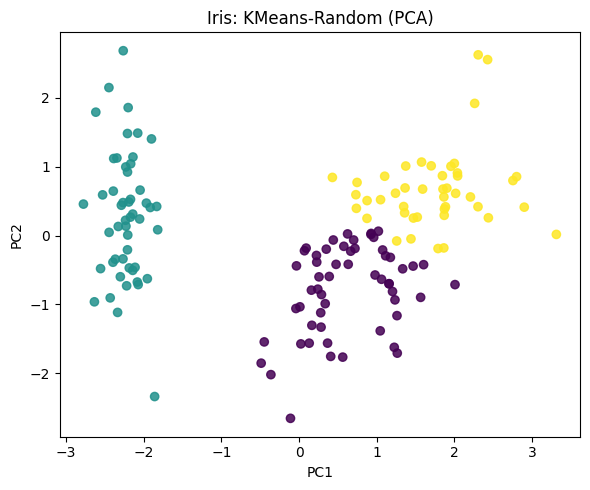

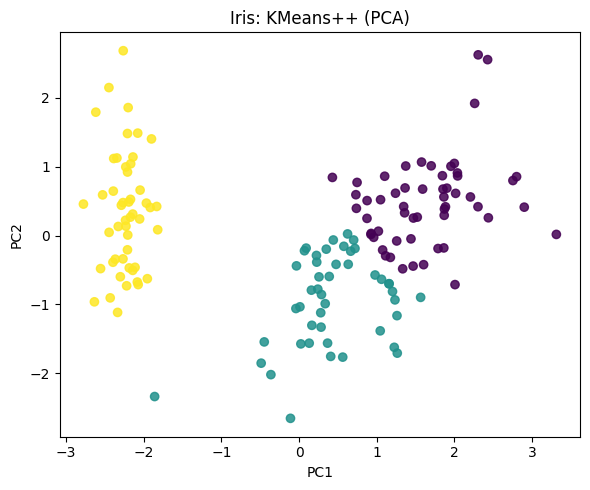

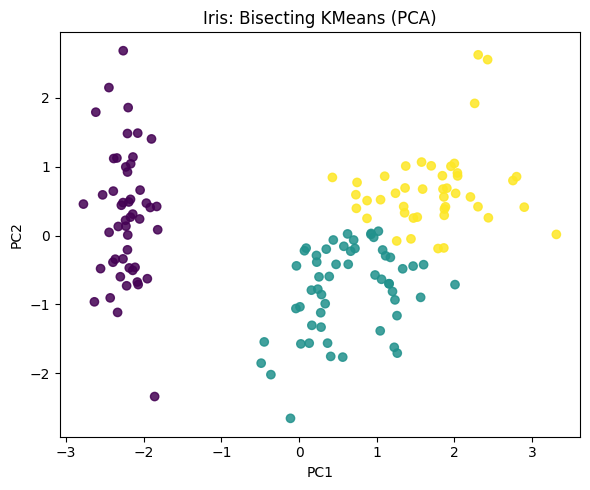

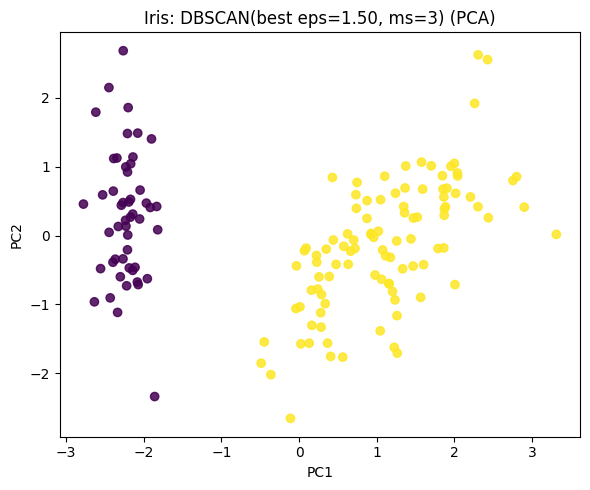

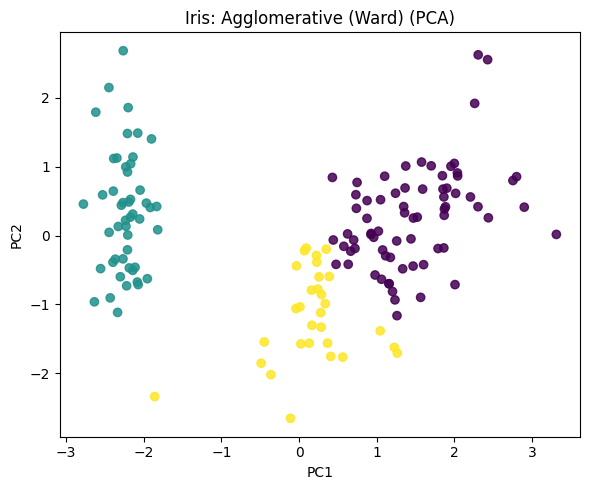

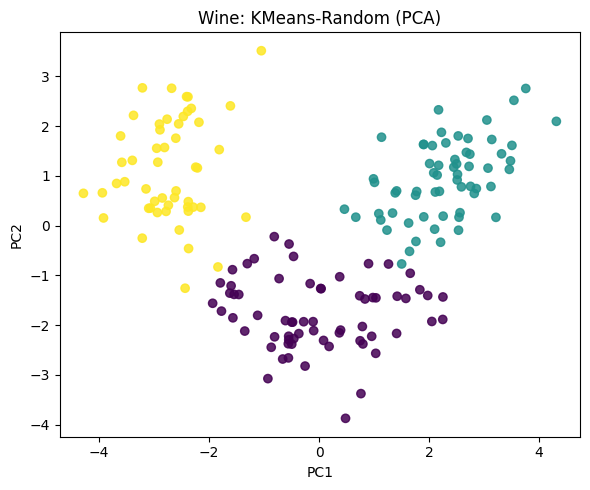

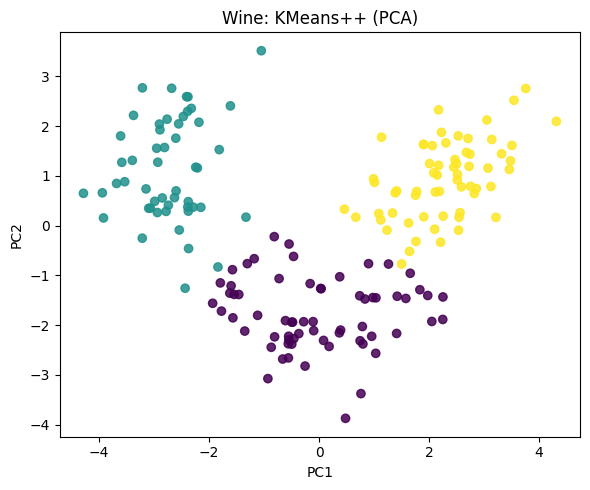

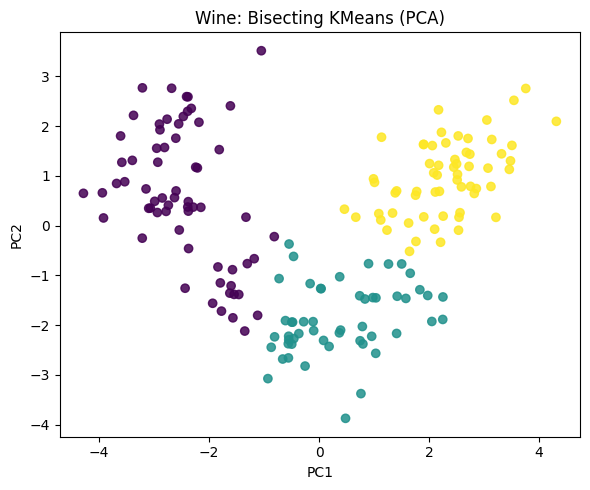

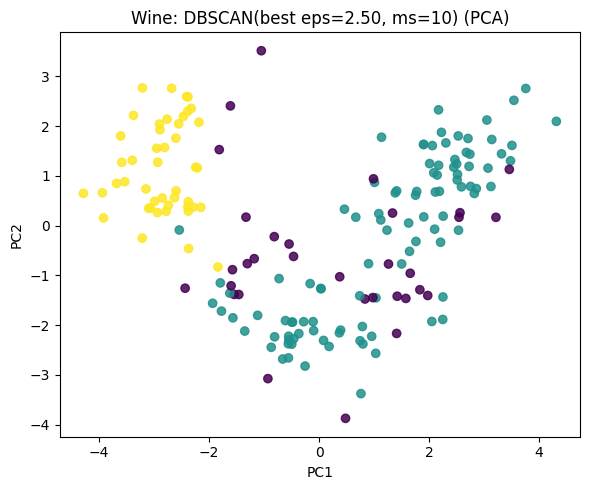

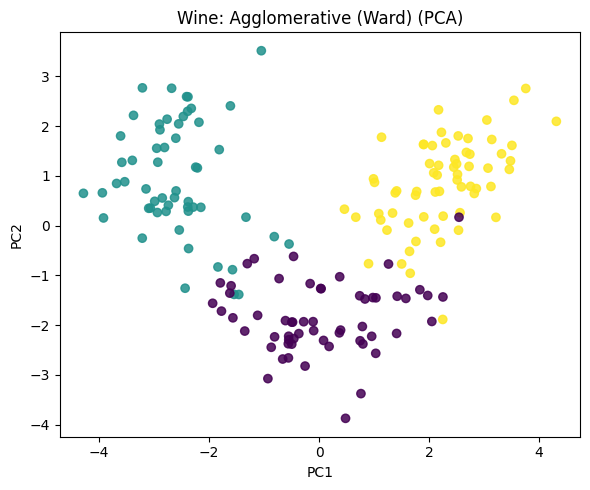

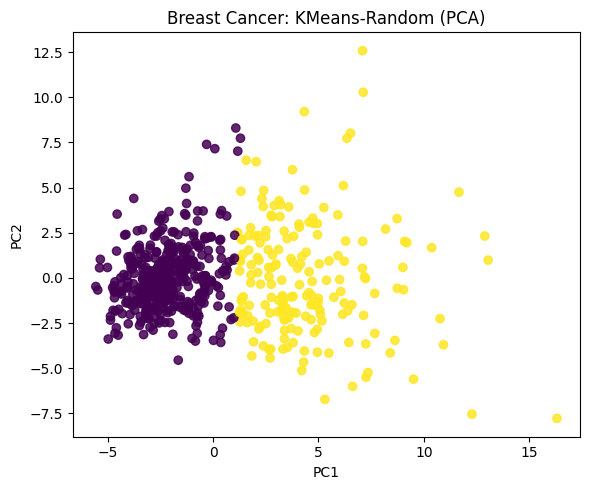

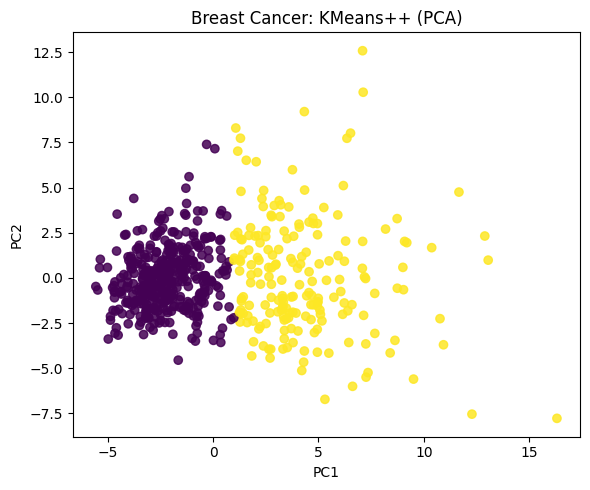

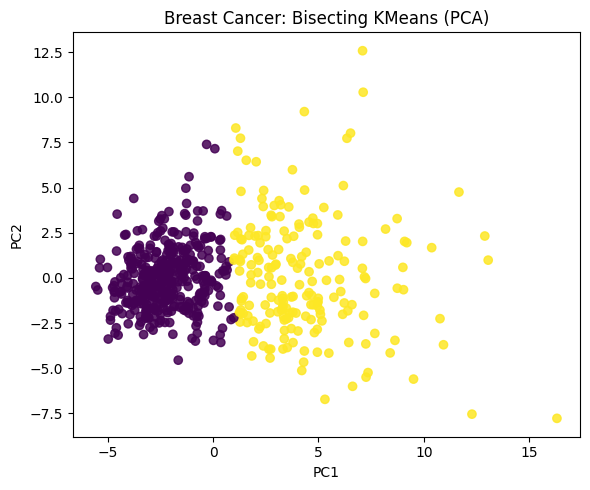

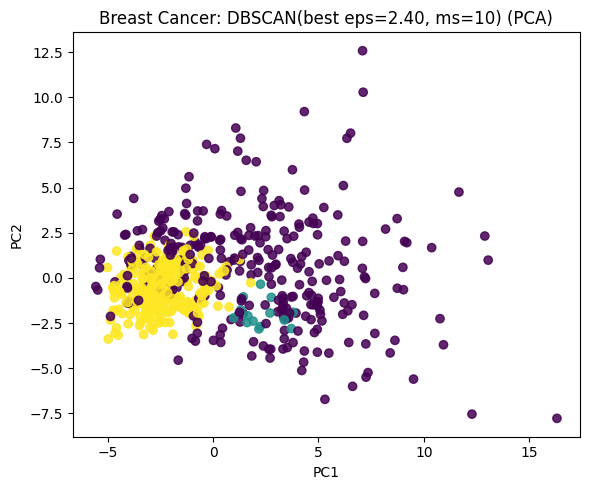

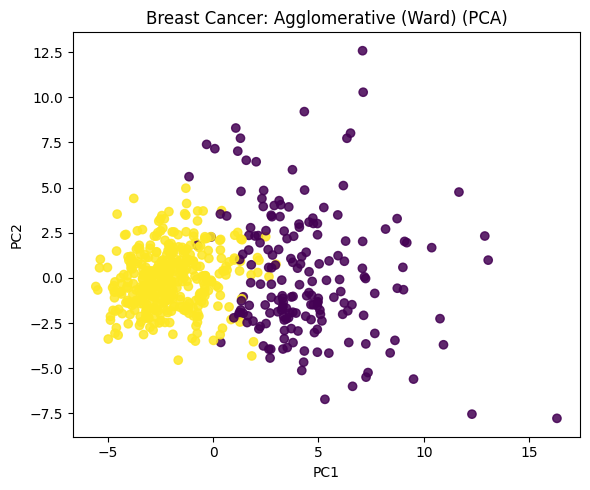

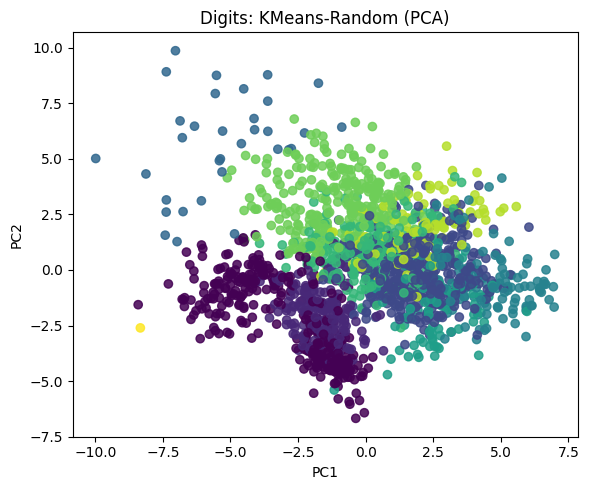

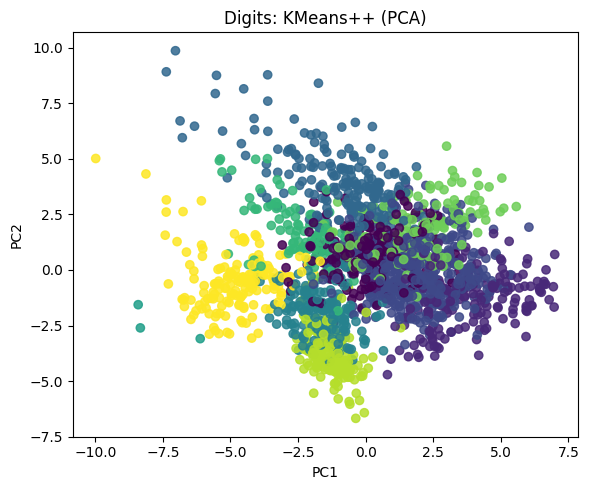

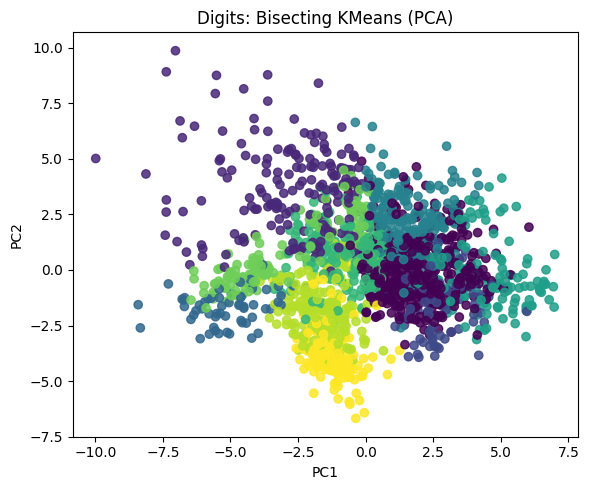

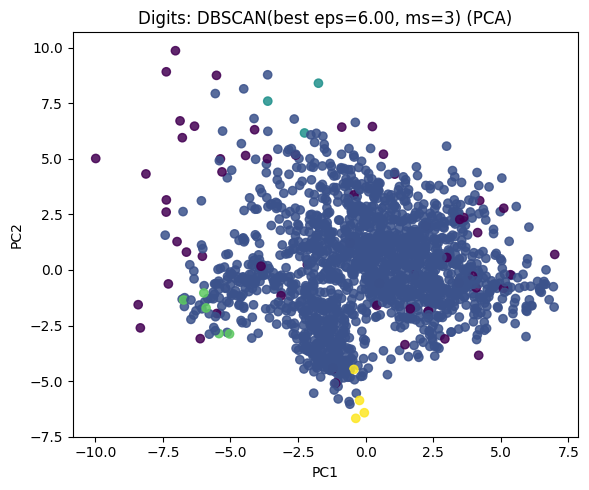

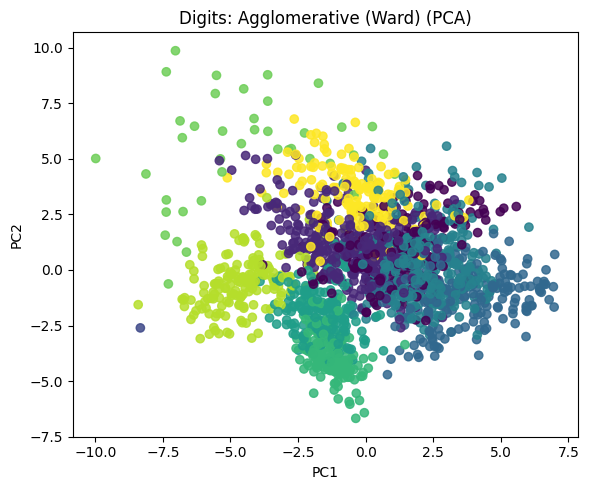

In [22]:
def labels_from_record(algo_name, X, k, random_state=42):
    if algo_name == 'KMeans-Random':
        return kmeans_fit(X, k, init='random', random_state=random_state)['labels']
    if algo_name == 'KMeans++':
        return kmeans_fit(X, k, init='kmeans++', random_state=random_state)['labels']
    if algo_name == 'Bisecting KMeans':
        return bisecting_kmeans(X, k, random_state=random_state)['labels']
    if algo_name.startswith('DBSCAN('):
        import re
        m = re.search(r"eps=([0-9.]+), ms=([0-9]+)", algo_name)
        if m:
            eps = float(m.group(1)); ms = int(m.group(2))
        else:
            eps, ms = 1.0, 5
        return DBSCAN(eps=eps, min_samples=ms).fit_predict(X)
    if algo_name == 'Agglomerative (Ward)':
        return AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
    if algo_name == 'Agglomerative (Complete)':
        return AgglomerativeClustering(n_clusters=k, linkage='complete').fit_predict(X)
    raise ValueError(algo_name)

for name, d in datasets_info.items():
    X, X2d, k = d['X'], d['X2d'], {'Iris':3,'Wine':3,'Breast Cancer':2,'Digits':10}[name]
    df = results_tables[name]
    algos = ['KMeans-Random','KMeans++','Bisecting KMeans']
    db_row = df[df['Algo'].str.startswith('DBSCAN(')].iloc[0] if (df['Algo'].str.startswith('DBSCAN(')).any() else None
    if db_row is not None:
        algos.append(db_row['Algo'])
    algos.append('Agglomerative (Ward)')
    for algo in algos:
        labels = labels_from_record(algo, X, k)
        plot_scatter_2d(X2d, labels, title=f"{name}: {algo} (PCA)")


**Reflection:**  
Implementing **k-means++** seeding and handling **dead clusters** were the trickiest pieces; I re-seeded empty clusters to keep iteration stable. **Bisecting K-Means** clarified how targeting the worst (highest SSE) cluster accelerates overall error reduction compared to blind restarts.

## 4. Algorithmic Comparison & Failure Modes

**Iris.** KMeans++ and Bisecting typically get the best **ARI** due to convex, compact clusters; DBSCAN works with a forgiving `eps`.

**Wine.** After scaling, **Agglomerative (Ward)** can rival K-Means; Complete linkage may chain points in skewed regions.

**Breast Cancer.** Non-spherical structure hurts K-Means; Ward often captures variance structure better; DBSCAN may mark many points as noise when `eps` is small.

**Digits.** High-dimensional, non-convex shapes cause K-Means to merge digits; DBSCAN is very sensitive; Agglomerative separates some digits but merges similar shapes.


**Reflection (Comparison, 2–3 sentences):**  
Distance geometry drives outcomes: K-Means assumes convex blobs, Ward minimizes within-cluster variance, and DBSCAN needs a **single global density scale**. Building and comparing side-by-side exposed these trade-offs far better than using a single library call.

## 5. Hyperparameter Sensitivity (Digits)

We sweep **K-Means** `k=2..8` and plot **inertia** & **silhouette**; then grid **DBSCAN** over `eps × min_samples` and plot a silhouette heatmap.

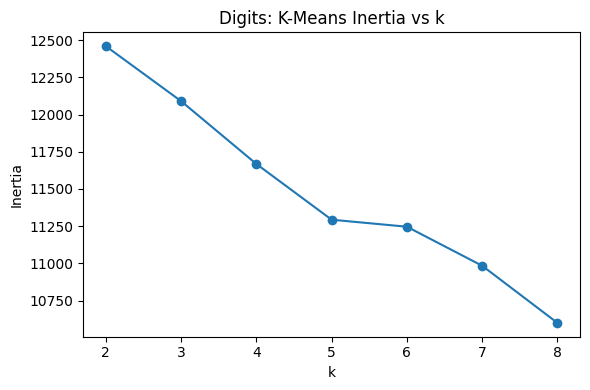

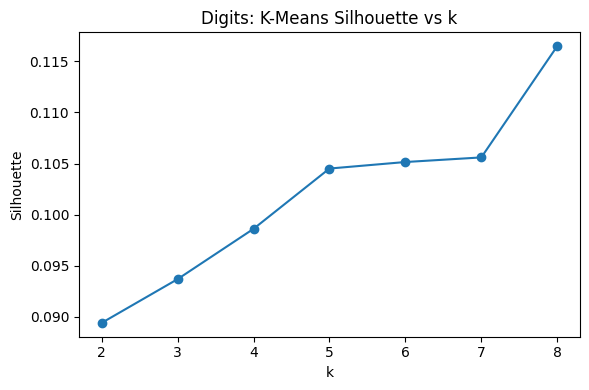

In [23]:
X = datasets_info['Digits']['X']
y = datasets_info['Digits']['y']
ks = list(range(2, 9))
inertias, sils = [], []
for k in ks:
    res = kmeans_fit(X, k, init='kmeans++', random_state=42)
    labels = res['labels']
    inertias.append(res['inertia'])
    if len(np.unique(labels)) > 1:
        try:
            sils.append(silhouette_score(X, labels))
        except Exception:
            sils.append(np.nan)
    else:
        sils.append(np.nan)
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.title('Digits: K-Means Inertia vs k')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.tight_layout(); plt.show()
plt.figure(figsize=(6,4))
plt.plot(ks, sils, marker='o')
plt.title('Digits: K-Means Silhouette vs k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.tight_layout(); plt.show()


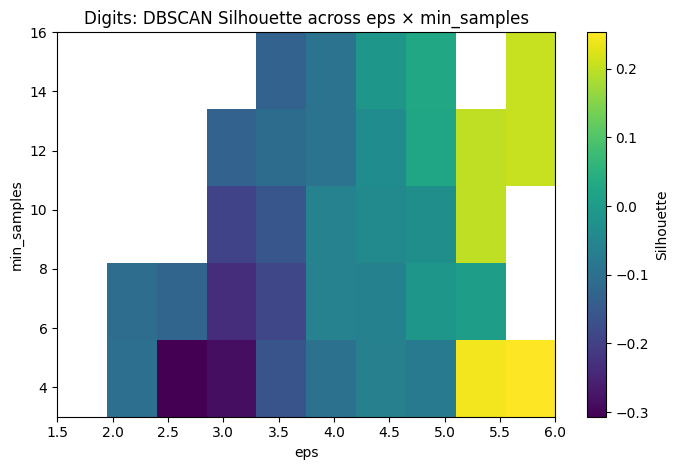

In [24]:
eps_grid = np.linspace(1.5, 6.0, 10)
min_samples_grid = [3,5,8,12,16]
heat = np.full((len(min_samples_grid), len(eps_grid)), np.nan)
for i, ms in enumerate(min_samples_grid):
    for j, eps in enumerate(eps_grid):
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X)
        valid = len(np.unique(labels[labels!=-1])) > 1
        if valid:
            try:
                heat[i,j] = silhouette_score(X, labels)
            except Exception:
                heat[i,j] = np.nan
plt.figure(figsize=(7,4.8))
plt.imshow(heat, aspect='auto', origin='lower',
           extent=[eps_grid[0], eps_grid[-1], min_samples_grid[0], min_samples_grid[-1]])
plt.colorbar(label='Silhouette')
plt.title('Digits: DBSCAN Silhouette across eps × min_samples')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.tight_layout(); plt.show()


**Reflection:**  
On Digits, inertia falls monotonically with **k**, but **silhouette** peaks early—classic elbow vs cohesion-tradeoff. DBSCAN shows narrow high-silhouette bands, underlining its sensitivity to both parameters in high-D spaces.

# Top 3 takes aways 


- **Assumptions matter:** K-Means prefers convex, equal-variance blobs; Ward handles elongated structure; DBSCAN thrives with a single **global density**.
- **Scale first:** Standardization is non-negotiable for Wine/Breast Cancer; otherwise distances are meaningless.
- **Tune with structure:** Use inertia/silhouette for K selection and **k-distance** heuristics for DBSCAN.